# Building an Recommendation Engine

## What is a Recommender System?

Today we live in a world of information overload. "Which phone should i buy? What is the best car? Which house should I get?" The list goes on and on.

There are a variety of strategies to solve such challenges in decision making. We can ask friends, experts, search the internet, or just making a best guess. 

The main goal of a recommender system is to assist users with this cognitive overload. See it as a personal advisor for the users. This will in turn translate to revenue and profit for the companies when users buy more, click more, or view more.

## The Recommendation Problem

It is a utiliy function that is trying to estimate or predict how a user will like an item. This prediction is going to based on data we collect such as past behavior, relations to other users, items similarity, context, and other. 

Recommenders have been around since at least 1992. Today we see different flavours of recommenders, deployed across different verticals: 

- Amazon
- Netflix
- Facebook
- Last.fm.

What exactly do they do?

### Definitions from the literature

- *In a typical recommender system people provide recommendations as inputs, which
the system then aggregates and directs to appropriate recipients.* -- Resnick
and Varian, 1997

- *Collaborative filtering simply means that people collaborate to help one
another perform filtering by recording their reactions to documents they read.*
-- Goldberg et al, 1992

- *In its most common formulation, the recommendation problem is reduced to the
problem of estimating ratings for the items that have not been seen by a
user. Intuitively, this estimation is usually based on the ratings given by this
user to other items and on some other information [...] Once we can estimate
ratings for the yet unrated items, we can recommend to the user the item(s) with
the highest estimated rating(s).* -- Adomavicius and Tuzhilin, 2005

- *Driven by computer algorithms, recommenders help consumers
by selecting products they will probably like and might buy
based on their browsing, searches, purchases, and preferences.* -- Konstan and Riedl, 2012

## Further Reading:

* [Coursera Recommendation System - Video Course](https://www.coursera.org/course/recsys)
* [Walkthrough of Hulu's Recommendation System](http://tech.hulu.com/blog/2011/09/19/recommendation-system/)
* [Xavier Amatriain @ Netflix](http://www.cikm2013.org/slides/xavier.pdf)
* [Mendeley RecSys](http://mendeley.github.io/mrec/)
* [Crab RecSys](http://muricoca.github.io/crab/tutorial.html#introducing-recommendation-engines)

### Problem statement

The recommendation problem in its most basic form is quite simple to define:

```
|-------------------+-----+-----+-----+-----+-----|
| user_id, movie_id | m_1 | m_2 | m_3 | m_4 | m_5 |
|-------------------+-----+-----+-----+-----+-----|
| u_1               | ?   | ?   | 4   | ?   | 1   |
|-------------------+-----+-----+-----+-----+-----|
| u_2               | 3   | ?   | ?   | 2   | 2   |
|-------------------+-----+-----+-----+-----+-----|
| u_3               | 3   | ?   | ?   | ?   | ?   |
|-------------------+-----+-----+-----+-----+-----|
| u_4               | ?   | 1   | 2   | 1   | 1   |
|-------------------+-----+-----+-----+-----+-----|
| u_5               | ?   | ?   | ?   | ?   | ?   |
|-------------------+-----+-----+-----+-----+-----|
| u_6               | 2   | ?   | 2   | ?   | ?   |
|-------------------+-----+-----+-----+-----+-----|
| u_7               | ?   | ?   | ?   | ?   | ?   |
|-------------------+-----+-----+-----+-----+-----|
| u_8               | 3   | 1   | 5   | ?   | ?   |
|-------------------+-----+-----+-----+-----+-----|
| u_9               | ?   | ?   | ?   | ?   | 2   |
|-------------------+-----+-----+-----+-----+-----|
```

Given a partially filled matrix of user ratings, estimate the missing values.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
df = pd.read_csv('data/coffee-pref-dat12.csv')
del df['Timestamp']

In [8]:
df.head()

,Name,Starbucks,PhilzCoffee,BlueBottleCoffee,PeetsTea,CaffeTrieste,GrandCoffee,RitualCoffee,FourBarrel,WorkshopCafe
0,Ramesh,3,NaN,NaN,4,NaN,NaN,NaN,NaN,4
1,Roger,3,3,5,NaN,4,2,NaN,NaN,NaN
2,R2,3,5,3,3,NaN,NaN,NaN,5,3
3,R3,NaN,NaN,NaN,5,NaN,4,4,3,NaN


In [28]:
 np.random.randn(1)

array([ 0.73807854])

In [33]:
def plot_items(df, item1, item2):
    fig, ax = plt.subplots(1, 1)
    df = df[['Name', item1, item2]].dropna()
    tot_rows = len(df)
    x_values = df[item1].values
    y_values = df[item2].values
    ax.scatter(x_values, y_values)
    ax.set_xlabel(item1)
    ax.set_ylabel(item2)
    for name, x, y in zip(df['Name'], x_values, y_values):
        ax.annotate(name, xy=(x,y))

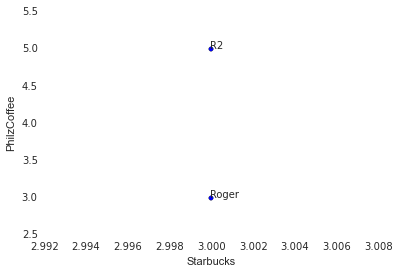

In [34]:
plot_items(df, 'Starbucks', 'PhilzCoffee')

### A few similarity functions

These were all written to operate on two pandas Series, each one representing the rating history of two different users. You can also apply them to any two feature vectors that describe users or items. In all cases, the higher the return value, the more similar two Series are. You might need to add checks for edge cases, such as divisions by zero, etc.

- Euclidean 'similarity'

$$ sim(x,y) = \frac{1}{1 + \sqrt{\sum (x - y)^2}}$$

- Cosine similarity

$$ sim(x,y) = \frac{(x . y)}{\sqrt{(x . x) (y . y)}} $$

- Pearson correlation

$$ sim(x,y) = \frac{(x - \bar x).(y - \bar y)}{\sqrt{(x - \bar x).(x - \bar x) * (y - \bar y)(y - \bar y)}} $$

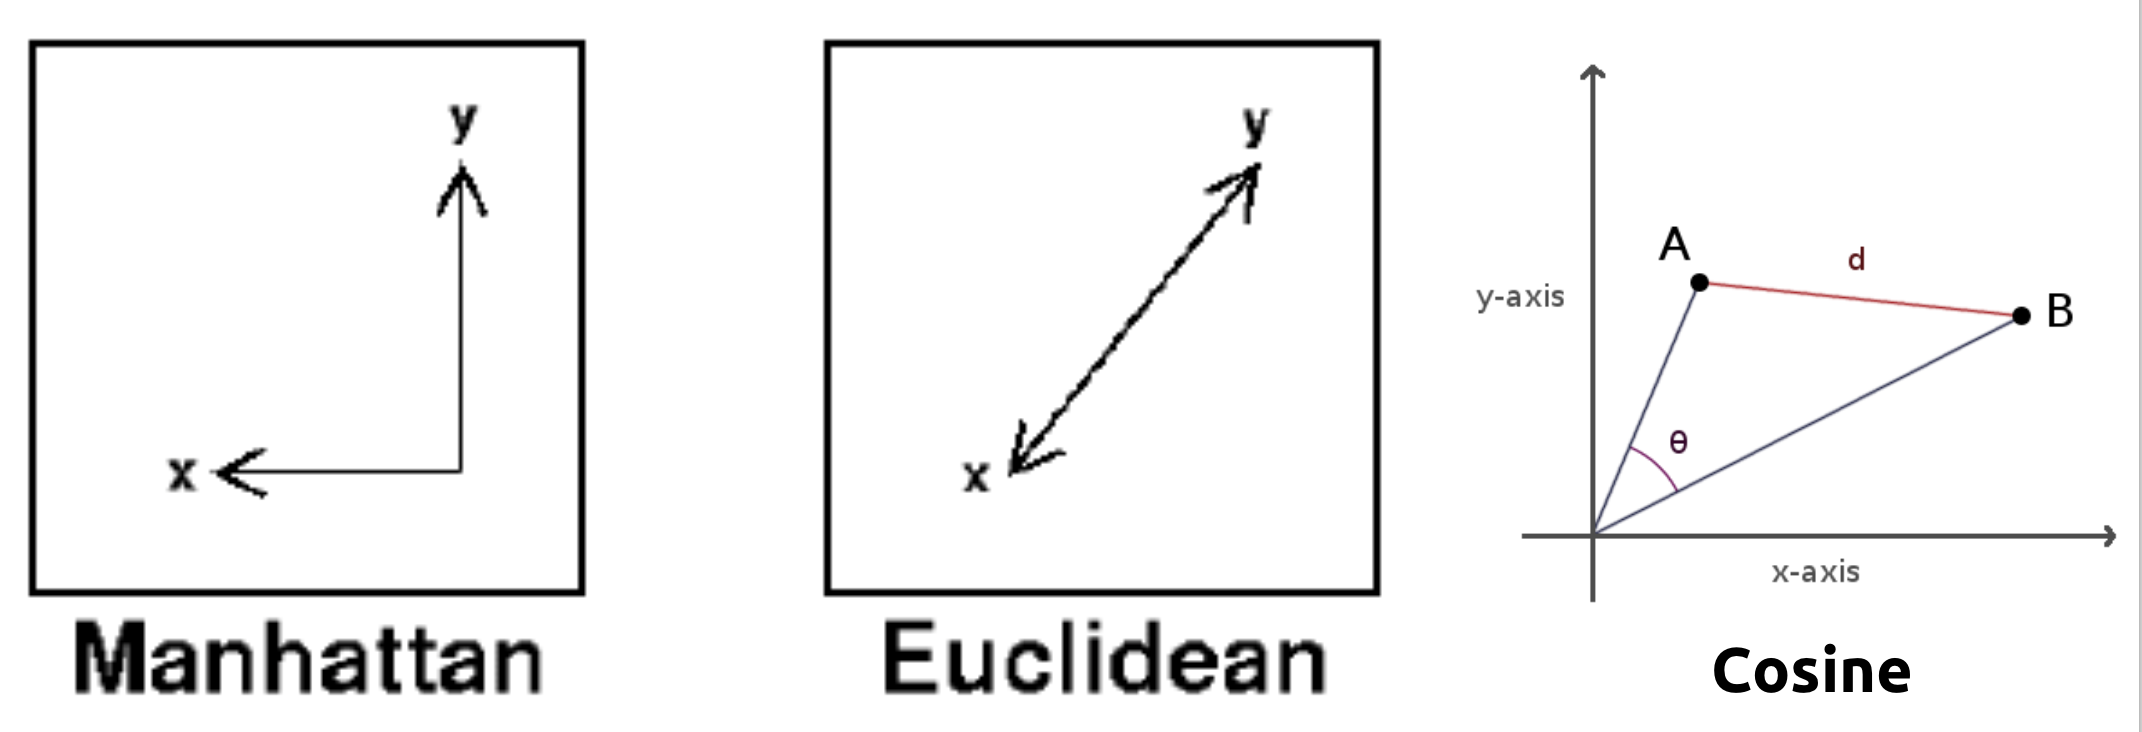

In [124]:
from IPython.core.display import Image

Image('sim_functions.png', width=900)

In [35]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

In [39]:
ratings_df = pd.melt(df, id_vars=['Name'], var_name='Coffee')

In [58]:
def calculate_similarity(df, item1, item2, sim_finc):
    df = df.dropna()
    item1_users = df[df['Coffee'] == item1].Name.unique()
    item2_users = df[df['Coffee'] == item2].Name.unique()
    common_users = set(item1_users).intersection(item2_users)
    user_mask = (df['Name'].isin(common_users))
    item1_mask = (df['Coffee'] == item1)
    item2_mask = (df['Coffee'] == item2)
    sim_value = sim_finc(df[user_mask & item1_mask].value, df[user_mask & item2_mask].value)
    return sim_value

In [61]:
calculate_similarity(ratings_df, 'Starbucks', 'PhilzCoffee', manhattan_distances)

array([[ 2.]])